In [ ]:
!pip install timm shap opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from timm import create_model
import shap
import cv2
import numpy as np
import matplotlib.pyplot as plt



In [ ]:

# 🧠 Load your trained ResNet (2-class output)
resnet = models.resnet50(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
resnet.load_state_dict(torch.load("/content/resnet_trained.pth", map_location=device))
resnet.to(device).eval()

# 🖼️ Load and preprocess image
image_path ='/content/RJVFE4SJ4V.jpg'  # <-- make sure this matches exactly
orig_image = cv2.imread(image_path)
if orig_image is None:
    raise FileNotFoundError(f"Image '{image_path}' not found.")
orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
input_tensor = transform(orig_image).unsqueeze(0).to(device)

# Replace all ReLU(inplace=True) with ReLU(inplace=False) to avoid SHAP crash
def remove_inplace_relu(module):
    for name, child in module.named_children():
        if isinstance(child, nn.ReLU) and child.inplace:
            setattr(module, name, nn.ReLU(inplace=False))
        else:
            remove_inplace_relu(child)

remove_inplace_relu(resnet)

class SafeResNet(nn.Module):
    def __init__(self, model):
        super(SafeResNet, self).__init__()
        self.model = model

    def forward(self, x):
        x = x.clone()  # Safe for SHAP
        return self.model(x)

safe_model = SafeResNet(resnet).to(device).eval()


safe_model = SafeResNet(resnet).to(device).eval()

# 🔍 SHAP background and explainer
background = torch.zeros((1, 3, 224, 224)).to(device)
explainer = shap.GradientExplainer(safe_model, background)
shap_values = explainer.shap_values(input_tensor)





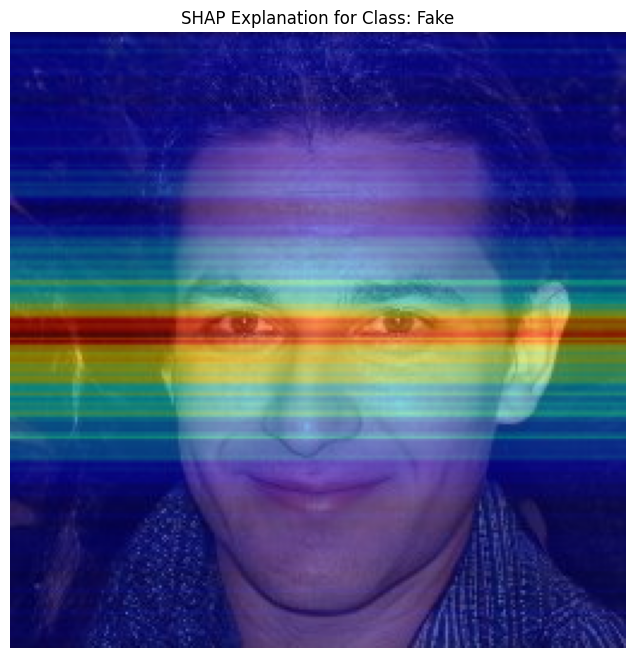

True

In [ ]:
# 🎯 Focus on class 1 (Fake)
shap_map = shap_values[0][0]  # Already NumPy array


heatmap = np.sum(np.abs(shap_map), axis=0)
heatmap -= heatmap.min()
if heatmap.max() != 0:
    heatmap /= heatmap.max()

# 🎨 Overlay heatmap on image
heatmap_uint8 = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
heatmap_color = cv2.resize(heatmap_color, (orig_image.shape[1], orig_image.shape[0]))

overlay = np.uint8(orig_image * 0.5 + heatmap_color * 0.5)

# 📸 Show result
plt.figure(figsize=(8, 8))
plt.imshow(overlay)
plt.axis('off')
plt.title("SHAP Explanation for Class: Fake")
plt.show()

# 💾 Optional: save
cv2.imwrite("resnet_fake_explanation.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

